In [14]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam, pyro_method
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace, replay
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam

from causal_pyro.query.do_messenger import do
from pyciemss.ODE.models import SVIIvR
from pyciemss.utils import run_inference, get_tspan

In [174]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    # ax.set_ylim(0, 120)
    # ax.set_ylim(0, 20)
    # ax.yaxis.set_tick_params(length=0)
    # ax.xaxis.set_tick_params(length=0)
    # ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    
    # for spine in ('top', 'right', 'bottom', 'left'):
        # ax.spines[spine].set_visible(False)

    return ax

In [175]:
def plot_predictive(prediction, tspan, tmin=None, ax=None, all_data=True, infected_label="Infected", infected_color='black'):
    vars = ["S_obs", "V_obs", "I_obs", "R_obs"]
    
    S_low, V_low, I_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(full_tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if all_data:
        ax.fill_between(tspan, S_low, S_up, color='b', alpha=0.2, label='Susceptible')
        ax.fill_between(tspan, V_low, V_up, color='purple', alpha=0.2, label='Vaccinated')
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], color=infected_color, alpha=0.2, label=infected_label)
    
    if all_data:
        ax.fill_between(tspan, R_low, R_up, color='green', alpha=0.2, label='Recovered')

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

In [176]:
def plot_trajectory(data, tspan, ax=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].detach().numpy()/1000., 'black', alpha=0.5, lw=0, marker='.')
    
    return ax

In [189]:
def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

In [178]:
observed_tspan = get_tspan(1, 7, 7)
new_tspan = get_tspan(7, 89, 83)
full_tspan = get_tspan(1, 89, 89)

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0.1, 81.0, 0.1, 0.1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))

ode_model = SVIIvR(N, 
                noise_prior=dist.Uniform(5., 10.),
                beta_prior=dist.Uniform(0.1, 0.3), 
                betaV_prior=dist.Uniform(0.025, 0.05),
                gamma_prior=dist.Uniform(0.05, 0.35),
                gammaV_prior=dist.Uniform(0.1, 0.4),
                nu_prior=dist.Uniform(0.001, 0.01))

# 18 - 24 year olds
I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])


## Forecasting - Ignoring Historical Data

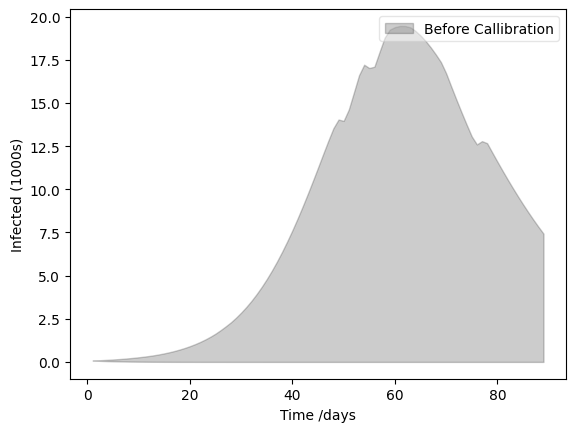

In [183]:
plotting_ode_model = pyro.condition(ode_model, {"noise_var": torch.tensor([0.000001])})
prior_prediction = Predictive(plotting_ode_model, num_samples=100)(initial_state, full_tspan)
ax = plot_predictive(prior_prediction, full_tspan, ax=setup_ax(), all_data=False, infected_label="Before Calibration")


## Forecasting - Incorporating Historical Data

In [184]:
from pyro import poutine

guide = AutoNormal(poutine.block(ode_model, hide=["S_obs", "V_obs", "R_obs"]))
# guide = AutoNormal(ode_model)
# data = {"S_obs":S_obs, "V_obs":V_obs, "I_obs":I_obs, "R_obs":R_obs}
# data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}
data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}

run_inference(ode_model, guide, initial_state, observed_tspan, data, num_iterations=200, verbose=True)

/Users/sam-basis/opt/anaconda3/envs/causal_pyro/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'S_obs', 'R_obs', 'V_obs'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[iteration 0001] loss: 113.7000
[iteration 0026] loss: 102.9717
[iteration 0051] loss: 104.0959
[iteration 0076] loss: 91.9949
[iteration 0101] loss: 89.4617
[iteration 0126] loss: 82.5820
[iteration 0151] loss: 94.0618
[iteration 0176] loss: 87.8210


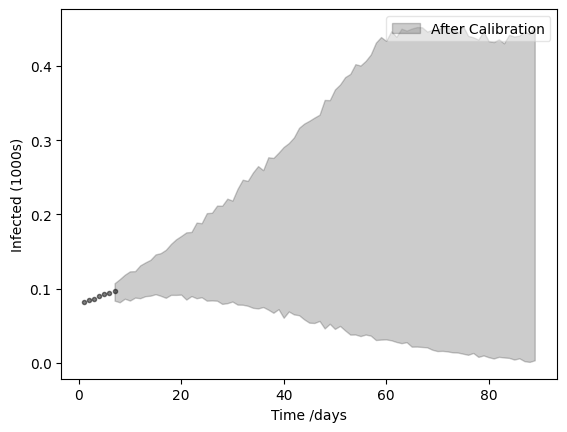

In [185]:
# Posterior predictive under our original model.
posterior_prediction = Predictive(plotting_ode_model, guide=guide, num_samples=100)(initial_state, full_tspan)

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, all_data=False, infected_label="After Calibration")

## Forecasting - Exploring Possible Interventions

In [186]:
# We can apply an intervention at local moments in time, as well as globally.
# Note: interventions as lambda expressions can only occur if we're explicit about time.

def constant_intervention(name, intervention_assignment, tspan):
    return {name + " %f" % (t): intervention_assignment for t in tspan}

def scheduled_intervention(name, intervention_assignment, tspan):
    index = lambda t : torch.floor(torch.tensor(t) / 30.).int()
    return {name + " %f" % (t): intervention_assignment[index(t)] for t in tspan}

def imperfect_intervention(name, intervention_assignment, tspan):
    return {name + " %f" % (t): lambda x : x + intervention_assignment for t in tspan}

constant_intervention_model = do(ode_model, constant_intervention("SV_flux", torch.tensor([1000.]), new_tspan))
scheduled_intervention_model = do(ode_model, scheduled_intervention("SV_flux", torch.tensor([1000.0, 500.0, 0.0]), new_tspan))
imperfect_intervention_model = do(ode_model, imperfect_intervention("SV_flux", torch.tensor([200.0]), new_tspan))

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_81585/3082754130.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = lambda t : torch.floor(torch.tensor(t) / 30.).int()


In [187]:
# Posterior predictive under our original model.
constant_intervention_prediction = Predictive(constant_intervention_model, guide=guide, num_samples=100)(initial_state, full_tspan)
scheduled_intervention_prediction = Predictive(scheduled_intervention_model, guide=guide, num_samples=100)(initial_state, full_tspan)
imperfect_intervention_prediction = Predictive(imperfect_intervention_model, guide=guide, num_samples=100)(initial_state, full_tspan)


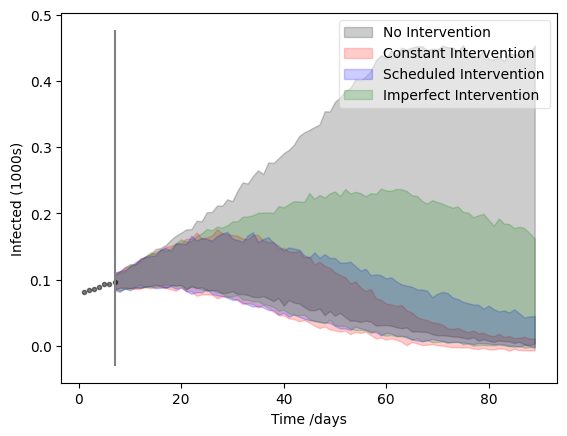

In [216]:
ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, all_data=False, infected_label="No Intervention")
ax = plot_predictive(constant_intervention_prediction, full_tspan, tmin=7, ax=ax, all_data=False, infected_color='red', infected_label="Constant Intervention")
ax = plot_predictive(scheduled_intervention_prediction, full_tspan, tmin=7, ax=ax, all_data=False, infected_color='blue', infected_label="Scheduled Intervention")
ax = plot_predictive(imperfect_intervention_prediction, full_tspan, tmin=7, ax=ax, all_data=False, infected_color='green', infected_label="Imperfect Intervention")
ax = plot_intervention_line(7., ax=ax)

## Optimization - Translating the Scenario Problem into Risk-based Optimization

Quantity of interest : 7 day average infections

controls : all the interventions from before

Anirban TODO: Show a bit of latex math and corresponding illustrations

## Optimization - Finding the Optimal Risk-aware Decision

In [ ]:
# Anirban TODO.

use_posterior = True

intervention_assignment = torch.tensor(0., requires_grad=True)
optimizer = torch.optim.Adam([intervention_assignment], lr=0.05)


# TODO: line this up with the scheduled_intervention controlled_models from before.
controlled_model = lambda int : do(ode_model, {"SV_flux %f" % (t): lambda x : x + int for t in tspan})(initial_state, tspan)

for i in range(500):
    if use_posterior:
        # Sample from the approximate posterior and replay through the model.
        # Note: Because we're using the Pytorch optimizer that targets tensors, we don't need to freeze guide parameters.
        guide_tr = trace(guide).get_trace(initial_state, tspan)
        model_tr = trace(replay(controlled_model, trace=guide_tr)).get_trace(intervention_assignment)
    else:
        model_tr = trace(controlled_model).get_trace(intervention_assignment)

    # If this value is positive, the constraint is not satisfied.
    relaxed_constraint = torch.max(model_tr.nodes["R_obs"]['value'][-1] - torch.tensor([100.]), torch.tensor([0.]))

    # Relaxed constrained optimization (flux is negative by default, therefore we want to penalize "smaller" flux values.)
    loss = -intervention_assignment + relaxed_constraint

    optimizer.zero_grad()
    loss.backward()

    if i % 10 == 0:
        print("[iteration %04d] loss: %.4f [intervention_assignment %.4f]" % (i + 1, loss, intervention_assignment))

    optimizer.step()